sudo PYTHONPATH=$PYTHONPATH:$PWD/CARLA_0.9.6/PythonAPI/carla/dist/carla-0.9.6-py3.5-linux-x86_64.egg ./../anaconda3/envs/c557/bin/jupyter notebook --allow-root


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import time
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
images = os.listdir("images")

In [4]:
tf.config.list_physical_devices("GPU")

[]

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 512

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   9232        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16384)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16384, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 16))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             8404992   
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        9280      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1)       577       
Total params: 8,451,777
Trainable params: 8,451,777
Non-trainable params: 0
_________________________________________________

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
def read_and_transform(path):
    img = cv2.imread(path)
    img = 0.5*img[:,:,0] + 0*img[:,:,1] + 0.5*img[:,:,2] #RGB
    return img.reshape( (256, 256,1) )/255

def read_transform(path):
    img = cv2.imread(path)/255
    img = 0.6*(img[76:204,76:204,0]) + 0.4*img[76:204,76:204,2] #RGB
    return img.reshape((128,128,1))
    
train_batch = np.zeros( (len(images), 128, 128, 1) )
for i, img in enumerate(images):
    train_batch[i] = read_transform(f'./images/{img}')
train_batch.shape

(1728, 128, 128, 1)

In [34]:
vae.fit(train_batch, epochs=5, batch_size=128)

Epoch 1/5
14/14 [==============================] - 25s 2s/step - loss: 8201.4752 - reconstruction_loss: 8138.5869 - kl_loss: 83.9199
Epoch 2/5
14/14 [==============================] - 25s 2s/step - loss: 8192.1888 - reconstruction_loss: 8119.7329 - kl_loss: 85.9374
Epoch 3/5
14/14 [==============================] - 25s 2s/step - loss: 8186.7015 - reconstruction_loss: 8114.6304 - kl_loss: 86.5068
Epoch 4/5
14/14 [==============================] - 25s 2s/step - loss: 8174.6784 - reconstruction_loss: 8101.7002 - kl_loss: 88.7714
Epoch 5/5
14/14 [==============================] - 25s 2s/step - loss: 8204.8008 - reconstruction_loss: 8087.0327 - kl_loss: 87.6460


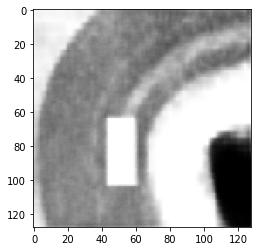

In [42]:
def getOut(path):
    inp = read_transform(path).reshape(1, 128, 128, 1)
    emb = encoder.predict(inp)[0]
    out = decoder.predict(emb)
    return out[0]
plt.imshow(getOut("images/img_1475.png"), cmap="gray")

(128, 128, 1)


(<matplotlib.image.AxesImage at 0x7fd2cc6eb2b0>, None)

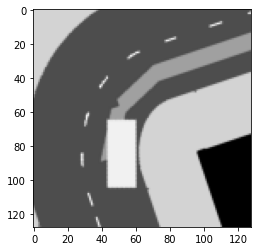

In [43]:
def read_transform(path):
    img = cv2.imread(path)/255
    img = 0.6*(img[76:204,76:204,0]) + 0.4*img[76:204,76:204,2] #RGB
    return img.reshape((128,128,1))
img = read_transform("images/img_1475.png")
plt.imshow(img, cmap="gray"), print(img.shape)

In [164]:
encoder.save('vae_encoder.h5')

In [101]:
# def sample(images, batch_size=64):
#     while True:
#         train_idx = np.random.choice( train_images, batch_size )
#         train_batch = np.zeros( (batch_size, 256, 256, 1) )

#         for i, img in enumerate(train_idx):
#             train_batch[i] = read_and_transform(f'./images/{img}')

#         yield train_batch

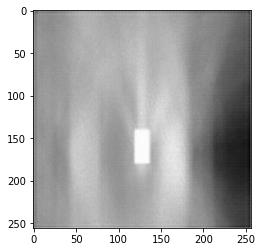